### Importing necessary libraries and packages

In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

### Read the directory of jsons,images and training and test data

In [2]:
directory = "archive/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "archive/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("archive/train.csv")
df_test = pd.read_csv("archive/submission.csv")

### Helper functions

In [3]:
protoPath = "archive/deploy.prototxt.txt"
modelPath= "archive/res10_300x300_ssd_iter_140000.caffemodel"
cvNet = cv2.dnn.readNetFromCaffe(protoPath,modelPath)
#retrieve the json files containing the bounding boxes data informations
def getJSON(filePathandName): 
    with open(filePathandName,'r') as f:
        return json.load(f)
# adjusting the gamma for adjusting the luminiosity of the image
# if gamma <1, the image will shift to the darker end of the spectrum and when gamma> 1, there will be more light in the image.
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

### Data processing and calculating the count of mask and no mask people from the image directory

In [4]:
data = []
img_size = 124 #image size
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json" #reading json file of each image
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask: #checking if the classname or in other words category is annotated as 'face_with_mask'
            x,y,w,h = j["BoundingBox"] #extrack bounding box dimentions (x_min,y_min,width,height) - > x_min and y_min is the top left corner of bounding box
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w] 
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]]) 
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)
#data will have image and it's corresponding label in each row
p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")

In [5]:
countnomask=0
countmask =0
for i in p:
    if(i=='No Mask'):
        countnomask = countnomask+1
    else:
        countmask = countmask+1
print("countnomask :",countnomask)
print("countmask :",countmask)

countnomask : 1569
countmask : 4180


The count above tells us that the number of mask images> Number of images without a mask, so this is an unbalanced dataset. But since we’re using a pre-trained SSD model, which is trained to detect unmasked faces, this imbalance wouldn’t matter much.

In [6]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)
# So X has images and Y has labels
X = np.array(X)/255.0 #scaling
X = X.reshape(-1,124,124,3) #reshape
Y = np.array(Y)

### Initializing the Neural Network

In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(124, 124, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

In [13]:
# train test split
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

In [14]:
len(xtrain)

4599

In [18]:
len(xval)

1150

### Data Augmentation (for more diversity in the input data)

In [15]:
datagen = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False,  
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,    
    rotation_range=15,    
    width_shift_range=0.1,
    height_shift_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=False
)
datagen.fit(xtrain)

In [20]:
history = model.fit(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32, 
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/50


C:\Users\neo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - accuracy: 0.7449 - loss: 0.6783 - val_accuracy: 0.8765 - val_loss: 0.3868
Epoch 2/50
  1/143 ━━━━━━━━━━━━━━━━━━━━ 6:57 3s/step - accuracy: 0.8438 - loss: 0.2677

C:\Users\neo\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.8438 - loss: 0.1348 - val_accuracy: 0.8748 - val_loss: 0.4011
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 463s 3s/step - accuracy: 0.8610 - loss: 0.3348 - val_accuracy: 0.9026 - val_loss: 0.2421
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.8438 - loss: 0.1956 - val_accuracy: 0.9070 - val_loss: 0.2324
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 465s 3s/step - accuracy: 0.9012 - loss: 0.2604 - val_accuracy: 0.9270 - val_loss: 0.2303
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.8438 - loss: 0.2716 - val_accuracy: 0.9209 - val_loss: 0.2252
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 425s 3s/step - accuracy: 0.9059 - loss: 0.2475 - val_accuracy: 0.9096 - val_loss: 0.2403
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.8125 - loss: 0.2039 - val_accuracy: 0.9157 - val_loss: 0.2325
Epoch 9/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 424s 3s/step - accuracy: 0.8878 - loss: 0.2607 - val_accurac

### Test the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


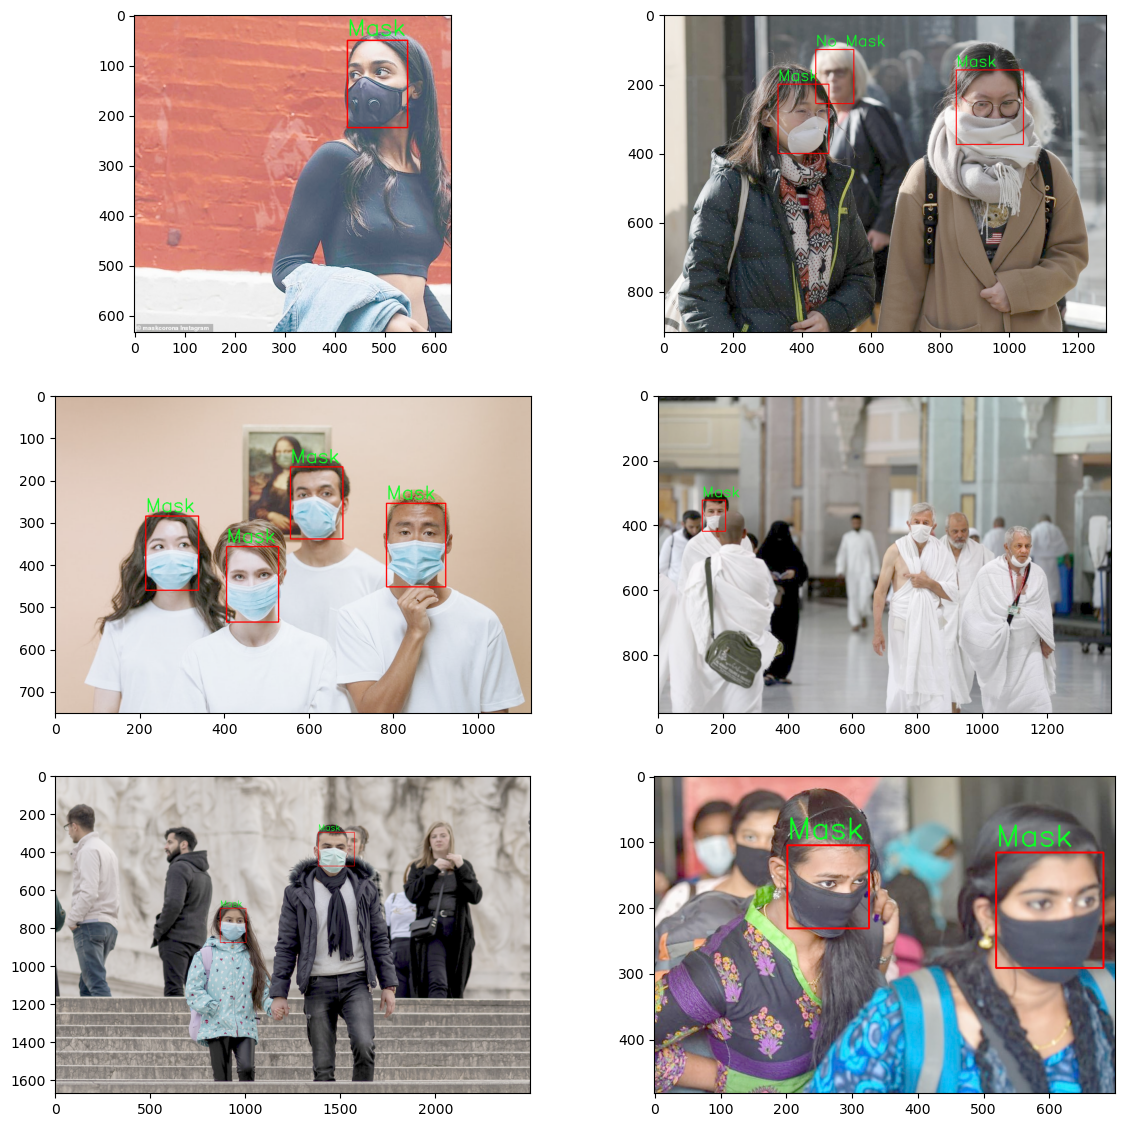

In [43]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images): #here j=index and im will be the file name
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2] #extracting just height and width
    #resizing image to (300,300) , performing no scaling (since scalefactor =1) , size of blob/output is (300,300), mean subtraction of channels (BGR)
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward() 
    for i in range(0, detections.shape[2]): # in this case it went through 200 iterations , since 200 detections were detected (200 bounding boxes)
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h]) #3:7 will give bounding box details
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX] #defining the region of interest (ROI)
            confidence = detections[0, 0, i, 2] #confidence is stored in 2
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size)) #why resize ? because we are giving this image to NN and we defined an input size of 124
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                # This line draws a rectangle around the detected object on the image. It takes the following arguments:
                #         image: The original image on which the rectangle will be drawn.
                #        (startX, startY): The coordinates of the top-left corner of the rectangle.
                #        (endX, endY): The coordinates of the bottom-right corner of the rectangle.
                #        (0, 0, 255): The color of the rectangle in BGR format. Here, it's red because it's (0, 0, 255).
                #        2: The thickness of the rectangle's border.
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                # This line adds text (a label) to the detected object. It takes the following arguments:
                 #   image: The original image on which the text will be added.
                 #   assign[str(label_Y)]: The text to be added. It seems like the label text is fetched from a dictionary assign using the label_Y as the key.
                 #   (startX, startY-10): The coordinates of the text. Here, it's slightly above the top-left corner of the rectangle.
                 #   cv2.FONT_HERSHEY_SIMPLEX: The font type.
                 #   1.5: The font scale factor.
                  #  (36,255,12): The color of the text in BGR format. Here, it's green because it's (36, 255, 12).
                 #   2: The thickness of the text.
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()            